In [1]:
%matplotlib inline
import glob
import os
import librosa
import numpy as np

import matplotlib.pyplot as plt
import tensorflow as tf
from data_aws.upload_data import upload, delete_dirs

In [2]:
# https://www.youtube.com/watch?v=MhOdbtPhbLU
# see if I can get one of these for conv layers
def extract_feature(file_name):
    X, sample_rate = librosa.load(file_name)
    # spectogram with shape 60 and 100
    melspec = librosa.feature.melspectrogram(X, n_mels = 60, sr=sample_rate)
    logspec = librosa.logamplitude(melspec)
    y_shape = logspec.shape[1]
    if y_shape < 101:
        diff= 101-y_shape
        mod = diff%2
        if mod==0:
            pad = int(diff/2)
            logspec = np.pad(logspec, [(0, 0), (pad, pad)], mode='constant')
        else:
            pad_left = int(np.floor(diff/2))
            pad_right = pad_left + 1
            logspec = np.pad(logspec, [(0, 0), (pad_left, pad_right)], mode='constant')
        
    return logspec[:,:100].reshape(1,60,100,1)

def parse_audio_files(parent_dir,sub_dirs,file_ext="*.wav"):
    features, labels = None, np.empty(0)
    for label, sub_dir in enumerate(sub_dirs):
        for fn in glob.glob(os.path.join(parent_dir, sub_dir, file_ext)):
            try:
                logspec = extract_feature(fn)
            except Exception as e:
                print( "Error encountered while parsing file: ", fn, str(e))
                continue
            if features is None:
                features = logspec
            else:
                features = np.concatenate((features,logspec), axis=0)
            labels = np.append(labels, fn.split('/')[2].split('-')[1])
    return np.array(features), np.array(labels, dtype = np.int)

def one_hot_encode(labels):
    n_labels = len(labels)
    n_unique_labels = 10#len(np.unique(labels))
    one_hot_encode = np.zeros((n_labels,n_unique_labels))
    one_hot_encode[np.arange(n_labels), labels] = 1
    return one_hot_encode

In [ ]:
parent_dir = 'data'
tr_sub_dirs = [["fold4","fold5"],["fold6","fold7"],["fold8","fold9"],["fold10"]]
for tr_sub_dir in tr_sub_dirs:
    upload(tr_sub_dir)
    # ts_sub_dirs = ["fold1"]
    tr_features_get, tr_labels_get = parse_audio_files(parent_dir,tr_sub_dir)
    # ts_features, ts_labels = parse_audio_files(parent_dir,ts_sub_dirs)

    tr_labels_get = one_hot_encode(tr_labels_get)

    
    tr_features = np.load('cnn_tr_features.npy')
    tr_labels = np.load('cnn_tr_labels.npy')
    tr_features = np.append(tr_features, tr_features_get, axis=0)
    tr_labels = np.append(tr_labels, tr_labels_get, axis=0)


    np.save('cnn_tr_features.npy', tr_features, allow_pickle=True)
    np.save('cnn_tr_labels.npy', tr_labels, allow_pickle=True)
    delete_dirs(tr_sub_dir)
    

In [3]:
tr_features = np.load('cnn_tr_features.npy')
tr_labels = np.load('cnn_tr_labels.npy')

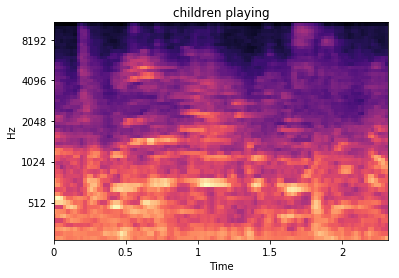

In [4]:
import librosa.display
sound_names = ["air conditioner","car horn","children playing",
"dog bark","drilling","engine idling", "gun shot",
"jackhammer","siren","street music"]
# print(sound_names[np.argmax(tr_labels[20])])
plt.figure()
plt.title('children playing')
librosa.display.specshow(tr_features[20].reshape(60,100), y_axis='mel',x_axis='time')
plt.show()

drilling


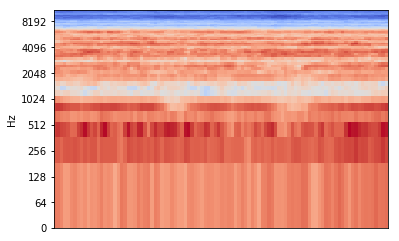

In [5]:
sound_names = ["air conditioner","car horn","children playing",
"dog bark","drilling","engine idling", "gun shot",
"jackhammer","siren","street music"]
print(sound_names[np.argmax(tr_labels[500])])
librosa.display.specshow(tr_features[500].reshape(60,100), y_axis='log')

In [11]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=(2,5), padding='same', activation='relu', 
                        input_shape=(60, 100, 1)))
model.add(MaxPooling2D(pool_size=(2,5)))
model.add(BatchNormalization())

model.add(Conv2D(filters=32, kernel_size=(2,5), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,5)))
model.add(BatchNormalization())

model.add(Conv2D(filters=64, kernel_size=(2,5), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())


model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(10, activation='softmax'))

model.summary()

# serialize model to JSON
model_json = model.to_json()
with open("cnn_model.json", "w") as json_file:
    json_file.write(model_json)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 60, 100, 16)       176       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 30, 20, 16)        0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 30, 20, 16)        64        
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 30, 20, 32)        5152      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 15, 4, 32)         0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 15, 4, 32)         128       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 15, 4, 64)         20544     
__________

In [12]:
# compile the model
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', 
                  metrics=['accuracy'])

# tr_features.shape

In [13]:
from keras.callbacks import ModelCheckpoint   
x_train, y_train = tr_features[:10000],tr_labels[:10000]
# x_valid, y_valid = tr_features[3000:4000],tr_labels[3000:4000]
x_test, y_test = tr_features[10000:],tr_labels[10000:]
# train the model
checkpointer = ModelCheckpoint(filepath='model.weights.best_cnn.hdf5', verbose=1, 
                               save_best_only=True)
hist = model.fit(x_train, y_train, batch_size=32, epochs=10,
          #validation_data=(x_valid, y_valid), 
          validation_split=0.25,
          callbacks=[checkpointer], 
          verbose=2, shuffle=True)



Train on 7500 samples, validate on 2500 samples
Epoch 1/10
Epoch 00000: val_loss improved from inf to 1.13949, saving model to model.weights.best_cnn.hdf5
26s - loss: 1.3846 - acc: 0.5621 - val_loss: 1.1395 - val_acc: 0.6100
Epoch 2/10
Epoch 00001: val_loss improved from 1.13949 to 0.88615, saving model to model.weights.best_cnn.hdf5
25s - loss: 0.8006 - acc: 0.7377 - val_loss: 0.8862 - val_acc: 0.7452
Epoch 3/10
Epoch 00002: val_loss did not improve
25s - loss: 0.6021 - acc: 0.8036 - val_loss: 1.1666 - val_acc: 0.6804
Epoch 4/10
Epoch 00003: val_loss improved from 0.88615 to 0.68936, saving model to model.weights.best_cnn.hdf5
25s - loss: 0.4854 - acc: 0.8449 - val_loss: 0.6894 - val_acc: 0.8120
Epoch 5/10
Epoch 00004: val_loss did not improve
25s - loss: 0.4072 - acc: 0.8672 - val_loss: 0.9765 - val_acc: 0.7624
Epoch 6/10
Epoch 00005: val_loss improved from 0.68936 to 0.54270, saving model to model.weights.best_cnn.hdf5
25s - loss: 0.3470 - acc: 0.8923 - val_loss: 0.5427 - val_acc: 0

In [14]:
# evaluate and print test accuracy
score = model.evaluate(x_test, y_test, verbose=0)
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 0.934417040359


In [ ]:
model.load_weights("model.weights.best_cnn.hdf5")
parent_dir = 'data'
tr_sub_dirs = ["my_data"]
# ts_sub_dirs = ["fold1"]

tr_features_get, tr_labels_get = parse_audio_files(parent_dir,tr_sub_dirs)
# ts_features, ts_labels = parse_audio_files(parent_dir,ts_sub_dirs)
print(tr_labels_get)
tr_labels_get = one_hot_encode(tr_labels_get)

# evaluate and print test accuracy
score = model.evaluate(tr_features_get, tr_labels_get, verbose=0)
print('\n', 'Test accuracy:', score[1])
print(np.argmax(model.predict(tr_features_get),axis=1))
# model.predict(tr_features_get).argsort(axis=1)

In [ ]:
from IPython.lib.display import Audio
print('blah blah')
Audio(data=None, filename='data/my_data/airconditionertube-0-blah.wav', url=None, embed=None, rate=None, autoplay=False)

In [ ]:
# plot a random sample of test images, their predicted labels, and ground truth
import librosa.display
fig = plt.figure(figsize=(20, 8))

for i, idx in enumerate(np.random.choice(tr_labels_get.shape[0], size=8, replace=False)):
    ax = fig.add_subplot(4, 8, i + 1, xticks=[], yticks=[])
    librosa.display.specshow(tr_features_get[idx,:,:,0], x_axis='time', y_axis='mel')
#     ax.imshow(np.squeeze(tr_features_get[idx]))
#     pred_idx = np.argmax(y_hat[idx])
#     true_idx = np.argmax(y_test[idx])
#     ax.set_title("{} ({})".format(cifar10_labels[pred_idx], cifar10_labels[true_idx]),
#                  color=("green" if pred_idx == true_idx else "red"))